In [1]:
from crocoddyl import *
import pinocchio as pin
import numpy as np
from crocoddyl.diagnostic import displayTrajectory

In [2]:
# LOAD ROBOT
robot = loadHector()
robot.initViewer(loadModel=True)
robot.display(robot.q0)

robot.framesForwardKinematics(robot.q0)

rmodel = robot.model

In [69]:
def uavPlacementModel(targetPos, targetQuat, integrationStep, frameName):
    # ACTUATION MODEL
    distanceRotorCOG = 0.1525
    cf = 6.6e-5
    cm = 1e-6
    actModel = ActuationModelUAM(robot.model, '+', distanceRotorCOG, cf, cm)

    # COST MODEL
    # Create a cost model per the running and terminal action model.
    runningCostModel = CostModelSum(rmodel, actModel.nu)
    terminalCostModel = CostModelSum(rmodel, actModel.nu)

    state = StatePinocchio(rmodel)
    SE3ref = pin.SE3()
    SE3ref.translation = targetPos.reshape(3,1)
    SE3ref.rotation = targetQuat.matrix()

    wBasePos  = [0.1]
    wBaseOri  = [100]
    wBaseVel  = [100]
    wBaseRate = [10]
    
    stateWeights   = np.array(wBasePos * 3 + wBaseOri * 3 + wBaseVel * robot.model.nv)
    controlWeights = np.array([1]*4)
    
    goalTrackingCost = CostModelFramePlacement(rmodel,
                                               frame=rmodel.getFrameId(frameName),
                                               ref=SE3ref,
                                               nu=actModel.nu)
    xRegCost = CostModelState(rmodel, 
                              state, 
                              ref=state.zero(), 
                              nu=actModel.nu,
                              activation=ActivationModelWeightedQuad(stateWeights))
    uRegCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelWeightedQuad(controlWeights))
    uLimCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelInequality(np.array([0.1, 0.1, 0.1, 0.1]), 
                                                                    np.array([5, 5, 5, 5])))

    # Then let's add the running and terminal cost functions
    runningCostModel.addCost(name="pos", weight=0.01, cost=goalTrackingCost)
    runningCostModel.addCost(name="regx", weight=1e-6, cost=xRegCost)
    runningCostModel.addCost(name="regu", weight=1e-6, cost=uRegCost)
    runningCostModel.addCost(name="limu", weight=1e-4, cost=uLimCost)
    terminalCostModel.addCost(name="pos", weight=50, cost=goalTrackingCost)

    # DIFFERENTIAL ACTION MODEL
    runningDmodel  = DifferentialActionModelActuated(rmodel, actModel, runningCostModel)
    terminalDmodel = DifferentialActionModelActuated(rmodel, actModel, terminalCostModel)
    runningModel = IntegratedActionModelEuler(runningDmodel)
    runningModel.timeStep =  integrationStep  
    terminalModel = IntegratedActionModelEuler(terminalDmodel)
    terminalModel.timeStep =  integrationStep  
    
    return runningModel,terminalModel   

In [70]:
# DEFINING THE SHOOTING PROBLEM & SOLVING

dt = 3e-2
T = 33

# DEFINE POSITION WAYPOINTS
target_pos = [np.array([0,0,1])]
target_pos += [np.array([0,1,1])]
quat = pin.Quaternion(1, 0, 0, 0)
quat.normalize()
target_quat = [quat]*2

# Plot goal frame
for i in range(0,len(target_pos)):
    robot.viewer.gui.addXYZaxis('world/wp%i' % i, [1., 0., 0., 1.], .03, 0.5)
    robot.viewer.gui.applyConfiguration('world/wp%i' % i, 
                                        target_pos[i].tolist() + [target_quat[i][0], target_quat[i][1], target_quat[i][2], target_quat[i][3]])
    
robot.viewer.gui.refresh()

In [71]:
models = []
# len(target_pos)
for i in range(1, 2):
    runningModel, terminalModel = uavPlacementModel(target_pos[i], target_quat[i], dt, 'base_link')
    models += [runningModel]*(T-1) + [terminalModel]

    
# From ground to 1st waypoint
q0 = robot.q0
x0 = np.hstack([m2a(q0), np.zeros(robot.model.nv)])

problem = ShootingProblem(x0, models[:-1], models[-1])

# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

# From 1st waypoint to 2nd waypoint
# x0 = np.array([ 3.64921977e-11, -2.33702527e-10,  9.99972616e-01,  7.55260190e-13, 
#               1.18488377e-13,  5.00281541e-18,  1.00000000e+00,  7.78469510e-08,
#                -4.97668391e-07, -4.04832071e-01,  1.15972591e-06,  1.81076620e-07, -9.47254507e-15])

us0 = [m.differential.quasiStatic(d.differential, problem.initialState)
       for m, d in zip(ddp.problem.runningModels, ddp.problem.runningDatas)]

xs0 = [problem.initialState]
N = len(problem.runningModels)
x_goal  = target_pos[1]
x_start = problem.initialState
for i in range(0, N):
    alpha = float(i)/float(N) 
    x_curr = x_start[:3] + alpha*(x_goal - x_start[:3])
    x_curr = np.append(x_curr, np.array([0,0,0,1] + [0]*rmodel.nv))
    xs0 = xs0 + [x_curr]

In [72]:
ddp.solve(init_xs=xs0, init_us=us0, maxiter=150)

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  1.49063e-01  1.43562e-04  1.11205e+00  1.00000e-09  1.00000e-09   0.5000     0
   1  1.44419e-01  4.04310e-05  2.98015e-01  1.00000e-09  1.00000e-09   0.5000     0
   2  1.41430e-01  1.70531e-05  1.74841e-01  1.00000e-09  1.00000e-09   0.1250     0
   3  1.62549e-01  1.17043e-05  2.15751e-02  1.00000e-09  1.00000e-09   1.0000     1
   4  1.53148e-01  1.25240e-05  1.51471e-01  1.00000e-09  1.00000e-09   0.1250     1
   5  1.51509e-01  4.15297e-06  1.60413e-02  1.00000e-09  1.00000e-09   0.2500     1
   6  1.49708e-01  4.91016e-06  2.97482e-02  1.00000e-09  1.00000e-09   0.1250     1
   7  1.48270e-01  3.41466e-06  1.19152e-02  1.00000e-09  1.00000e-09   0.2500     1
   8  1.46923e-01  3.69564e-06  2.10745e-02  1.00000e-09  1.00000e-09   0.1250     1
   9  1.45710e-01  2.77103e-06  9.21471e-03  1.00000e-09  1.00000e-09   0.2500     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  1.44663e

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  90  1.34893e-01  2.91875e-09  1.14777e-05  1.00000e-09  1.00000e-09   0.2500     1
  91  1.34891e-01  3.81864e-09  3.11718e-05  1.00000e-09  1.00000e-09   0.1250     1
  92  1.34890e-01  2.86724e-09  1.65333e-05  1.00000e-09  1.00000e-09   0.1250     1
  93  1.34890e-01  2.34551e-09  1.04444e-05  1.00000e-09  1.00000e-09   0.2500     1
  94  1.34889e-01  3.66078e-09  3.55623e-05  1.00000e-09  1.00000e-09   0.1250     1
  95  1.34888e-01  2.41271e-09  1.66945e-05  1.00000e-09  1.00000e-09   0.1250     1
  96  1.34888e-01  1.87561e-09  8.15072e-06  1.00000e-09  1.00000e-09   0.2500     1
  97  1.34887e-01  2.60268e-09  2.36205e-05  1.00000e-09  1.00000e-09   0.1250     1
  98  1.34886e-01  1.85305e-09  1.14409e-05  1.00000e-09  1.00000e-09   0.1250     1
  99  1.34885e-01  1.50861e-09  7.35515e-06  1.00000e-09  1.00000e-09   0.1250     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
 100  1.34885e

([array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([-6.20464074e-07,  5.53926180e-04,  1.10871654e-02, -4.98986956e-02,
         -1.09026993e-04, -1.59607050e-03,  9.98753003e-01,  0.00000000e+00,
          0.00000000e+00,  3.70186867e-01, -3.32796314e+00, -7.27148899e-03,
         -1.06448951e-01]),
  array([-1.21004983e-06,  3.75061235e-03,  3.33491575e-02, -1.02684987e-01,
         -6.86382934e-05, -1.33111686e-03,  9.94713032e-01, -3.02161576e-05,
         -7.62540239e-03,  7.49989401e-01, -3.52978846e+00, -3.84003489e-03,
          1.77379963e-02]),
  array([-1.58431907e-07,  1.11048995e-02,  6.60993206e-02, -1.41608622e-01,
         -6.52544898e-05, -9.89373737e-04,  9.89922227e-01, -6.85144909e-05,
         -2.69237213e-02,  1.11882089e+00, -2.61465513e+00, -5.59254805e-03,
          2.24443096e-02]),
  array([ 2.62553211e-06,  2.33727013e-02,  1.08232498e-01, -1.62518146e-01,
         -8.09875740e-05, -7.19330240e-04,  9.86705289e-01, -1.94180777e-05,
      

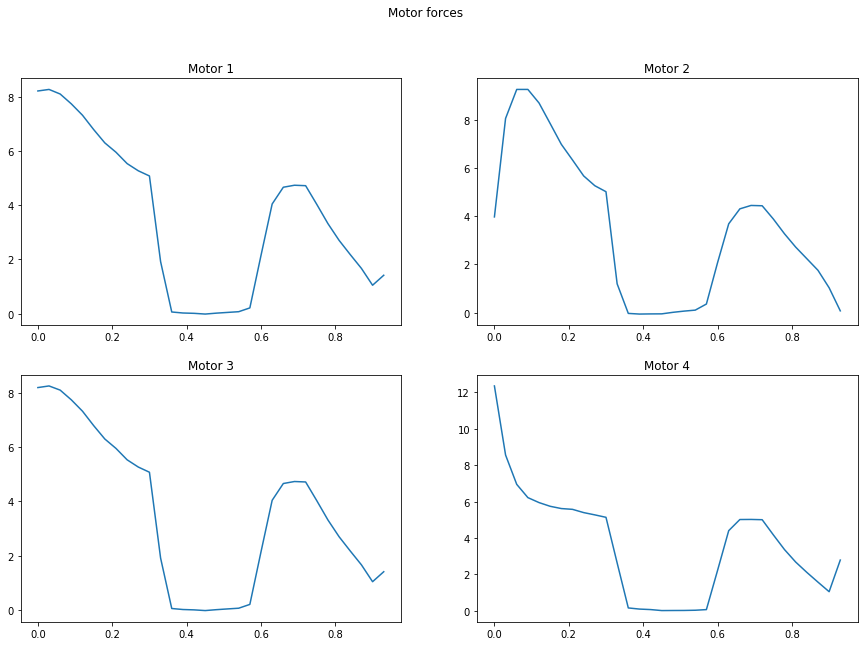

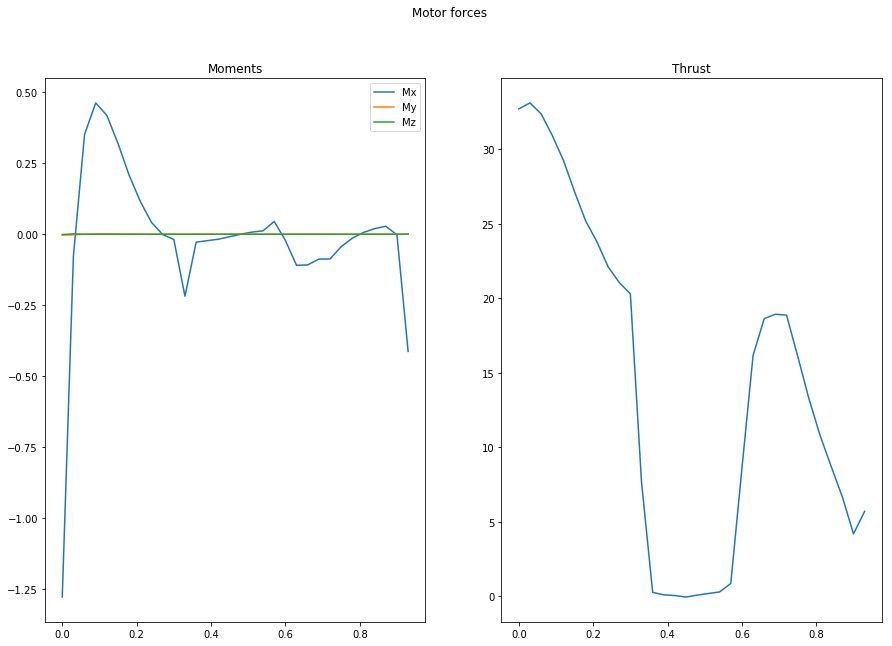

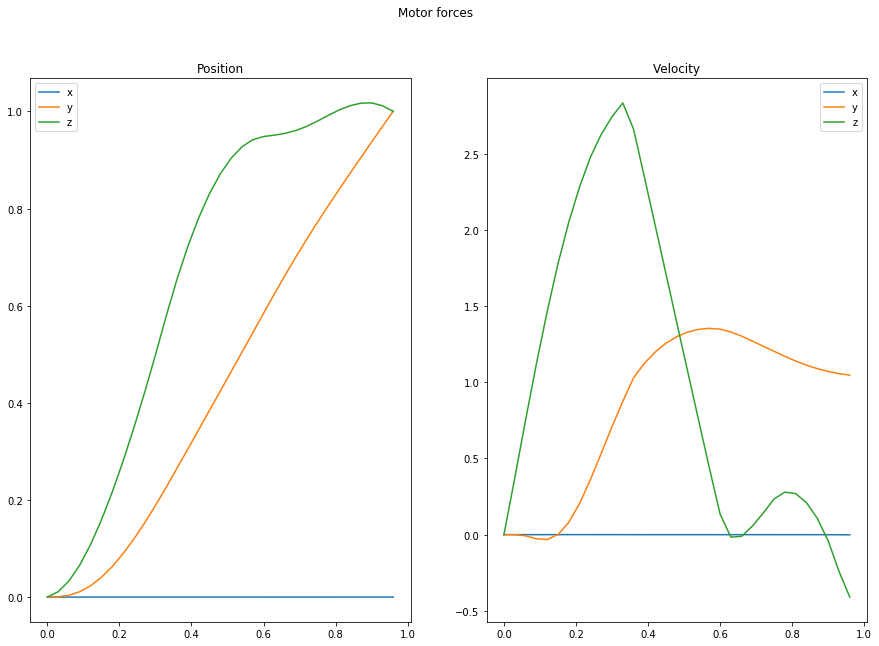

In [73]:
distanceRotorCOG = 0.1525
cf = 6.6e-5
cm = 1e-6
pltUAM = PlotUAM('+', ddp.xs, ddp.us, np.size(ddp.us,0), dt, distanceRotorCOG, cf, cm)

pltUAM.plotMotorForces();
pltUAM.plotFlyingPlatformActuation();
pltUAM.plotFlyingPlatformState();

In [74]:
displayTrajectory(robot, ddp.xs, dt)